# Fine-tune ViT on Animals Dataset
This section fine-tunes `google/vit-base-patch16-224` on the animals151 dataset

In [1]:
import os
from pathlib import Path
import random
from contextlib import nullcontext
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification, get_linear_schedule_with_warmup

C:\Users\fired\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Repro + device
seed = 91202
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

DATA_ROOT = Path("animals141/dataset/dataset")
assert DATA_ROOT.exists(), f"Not found: {DATA_ROOT.resolve()}"

device: cuda


In [ ]:
model_id = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_id)

image_size = processor.size.get("height", 224)
mean = processor.image_mean
std = processor.image_std

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_tfms = transforms.Compose([
    transforms.Resize(image_size, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
base_dataset = datasets.ImageFolder(root=DATA_ROOT)
class_names = base_dataset.classes
num_classes = len(class_names)
print("num_classes:", num_classes)

val_frac = 0.10
val_size = int(len(base_dataset) * val_frac)
generator = torch.Generator().manual_seed(seed)
perm = torch.randperm(len(base_dataset), generator=generator).tolist()
val_idx = perm[:val_size]
train_idx = perm[val_size:]

train_full = datasets.ImageFolder(root=DATA_ROOT, transform=train_tfms)
val_full = datasets.ImageFolder(root=DATA_ROOT, transform=val_tfms)
train_dataset = Subset(train_full, train_idx)
val_dataset = Subset(val_full, val_idx)

batch_size = 32
num_workers = 4
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    pin_memory=(device.type == "cuda"), drop_last=True
 )
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
    pin_memory=(device.type == "cuda")
 )

print("train images:", len(train_dataset), "val images:", len(val_dataset))
print("train batches:", len(train_loader), "val batches:", len(val_loader))

num_classes: 151
train images: 5643 val images: 627
train batches: 176 val batches: 20


In [6]:
id2label = {i: name for i, name in enumerate(class_names)}
label2id = {name: i for i, name in enumerate(class_names)}

model = AutoModelForImageClassification.from_pretrained(
    model_id,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(device)
model.train()

print("model num_labels:", model.config.num_labels)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([151]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([151, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model num_labels: 151


In [ ]:
epochs = 10
lr = 3e-4
weight_decay = 1e-2
warmup_ratio = 0.05
max_grad_norm = 1.0

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
num_training_steps = epochs * len(train_loader)
num_warmup_steps = int(warmup_ratio * num_training_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
 )

use_amp = (device.type == "cuda")

try:
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)
except Exception:
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
print({"steps": num_training_steps, "warmup": num_warmup_steps, "amp": use_amp, "device": device.type})

{'steps': 1760, 'warmup': 88, 'amp': True, 'device': 'cuda'}


In [ ]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    for batch in tqdm(data_loader, desc="eval", leave=False):
        pixel_values, labels = batch
        pixel_values = pixel_values.to(device, non_blocking=True).contiguous()
        labels = labels.to(device, non_blocking=True)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))

        preds = torch.argmax(logits, dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() * labels.size(0)
    acc = correct / max(1, total)
    avg_loss = total_loss / max(1, total)
    model.train()
    return {"val_loss": avg_loss, "val_acc": acc}

In [ ]:
def train_one_epoch(model, data_loader, epoch):
    model.train()
    running_loss = 0.0
    seen = 0
    pbar = tqdm(data_loader, desc=f"train epoch {epoch}")
    for pixel_values, labels in pbar:
        pixel_values = pixel_values.to(device, non_blocking=True).contiguous()
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            try:
                amp_ctx = torch.amp.autocast(device_type="cuda", enabled=True)
            except Exception:
                amp_ctx = torch.cuda.amp.autocast(enabled=True)
            with amp_ctx:
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

        scheduler.step()

        running_loss += loss.item() * labels.size(0)
        seen += labels.size(0)
        pbar.set_postfix(loss=running_loss / max(1, seen))
    return {"train_loss": running_loss / max(1, seen)}

In [ ]:
output_dir = Path("outputs/vit-animals")
output_dir.mkdir(parents=True, exist_ok=True)

best_val_acc = -1.0
history = []

for epoch in range(1, epochs + 1):
    train_stats = train_one_epoch(model, train_loader, epoch)
    val_stats = evaluate(model, val_loader)
    stats = {"epoch": epoch, **train_stats, **val_stats}
    history.append(stats)
    print(stats)

    if val_stats["val_acc"] > best_val_acc:
        best_val_acc = val_stats["val_acc"]
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)
        print(f"saved new best checkpoint to {output_dir} (val_acc={best_val_acc:.4f})")

history

train epoch 1: 100%|██████████| 176/176 [00:46<00:00,  3.80it/s, loss=1.95]


{'epoch': 1, 'train_loss': 1.9486751746047626, 'val_loss': 0.5404091687483841, 'val_acc': 0.8660287081339713}
saved new best checkpoint to outputs\vit-animals (val_acc=0.8660)


train epoch 2: 100%|██████████| 176/176 [00:43<00:00,  4.03it/s, loss=0.283] 


{'epoch': 2, 'train_loss': 0.28333250111476943, 'val_loss': 0.4744966119480285, 'val_acc': 0.8803827751196173}
saved new best checkpoint to outputs\vit-animals (val_acc=0.8804)


train epoch 3: 100%|██████████| 176/176 [00:43<00:00,  4.06it/s, loss=0.141] 


{'epoch': 3, 'train_loss': 0.140939905308187, 'val_loss': 0.4552257140857751, 'val_acc': 0.8899521531100478}
saved new best checkpoint to outputs\vit-animals (val_acc=0.8900)


train epoch 4: 100%|██████████| 176/176 [00:42<00:00,  4.12it/s, loss=0.075] 


{'epoch': 4, 'train_loss': 0.07503655379299413, 'val_loss': 0.40634659146578117, 'val_acc': 0.9027113237639554}
saved new best checkpoint to outputs\vit-animals (val_acc=0.9027)


train epoch 5: 100%|██████████| 176/176 [00:42<00:00,  4.14it/s, loss=0.0353] 


{'epoch': 5, 'train_loss': 0.03528656649657271, 'val_loss': 0.3853177319873463, 'val_acc': 0.9170653907496013}
saved new best checkpoint to outputs\vit-animals (val_acc=0.9171)


train epoch 6: 100%|██████████| 176/176 [00:43<00:00,  4.02it/s, loss=0.018]  


{'epoch': 6, 'train_loss': 0.01797376103191213, 'val_loss': 0.3106707210936234, 'val_acc': 0.9346092503987241}
saved new best checkpoint to outputs\vit-animals (val_acc=0.9346)


train epoch 7: 100%|██████████| 176/176 [00:43<00:00,  4.00it/s, loss=0.00555] 


{'epoch': 7, 'train_loss': 0.005553368225016377, 'val_loss': 0.31001108765982366, 'val_acc': 0.9330143540669856}


train epoch 8: 100%|██████████| 176/176 [00:43<00:00,  4.03it/s, loss=0.0026] 


{'epoch': 8, 'train_loss': 0.0025956439785659313, 'val_loss': 0.2760607060252955, 'val_acc': 0.937799043062201}
saved new best checkpoint to outputs\vit-animals (val_acc=0.9378)


train epoch 9: 100%|██████████| 176/176 [00:43<00:00,  4.04it/s, loss=0.0017]  


{'epoch': 9, 'train_loss': 0.0017021969384090467, 'val_loss': 0.2779187495438486, 'val_acc': 0.9409888357256778}
saved new best checkpoint to outputs\vit-animals (val_acc=0.9410)


train epoch 10: 100%|██████████| 176/176 [00:43<00:00,  4.01it/s, loss=0.00116] 


{'epoch': 10, 'train_loss': 0.0011638334571299229, 'val_loss': 0.2780653972659955, 'val_acc': 0.9409888357256778}


[{'epoch': 1,
  'train_loss': 1.9486751746047626,
  'val_loss': 0.5404091687483841,
  'val_acc': 0.8660287081339713},
 {'epoch': 2,
  'train_loss': 0.28333250111476943,
  'val_loss': 0.4744966119480285,
  'val_acc': 0.8803827751196173},
 {'epoch': 3,
  'train_loss': 0.140939905308187,
  'val_loss': 0.4552257140857751,
  'val_acc': 0.8899521531100478},
 {'epoch': 4,
  'train_loss': 0.07503655379299413,
  'val_loss': 0.40634659146578117,
  'val_acc': 0.9027113237639554},
 {'epoch': 5,
  'train_loss': 0.03528656649657271,
  'val_loss': 0.3853177319873463,
  'val_acc': 0.9170653907496013},
 {'epoch': 6,
  'train_loss': 0.01797376103191213,
  'val_loss': 0.3106707210936234,
  'val_acc': 0.9346092503987241},
 {'epoch': 7,
  'train_loss': 0.005553368225016377,
  'val_loss': 0.31001108765982366,
  'val_acc': 0.9330143540669856},
 {'epoch': 8,
  'train_loss': 0.0025956439785659313,
  'val_loss': 0.2760607060252955,
  'val_acc': 0.937799043062201},
 {'epoch': 9,
  'train_loss': 0.001702196938409

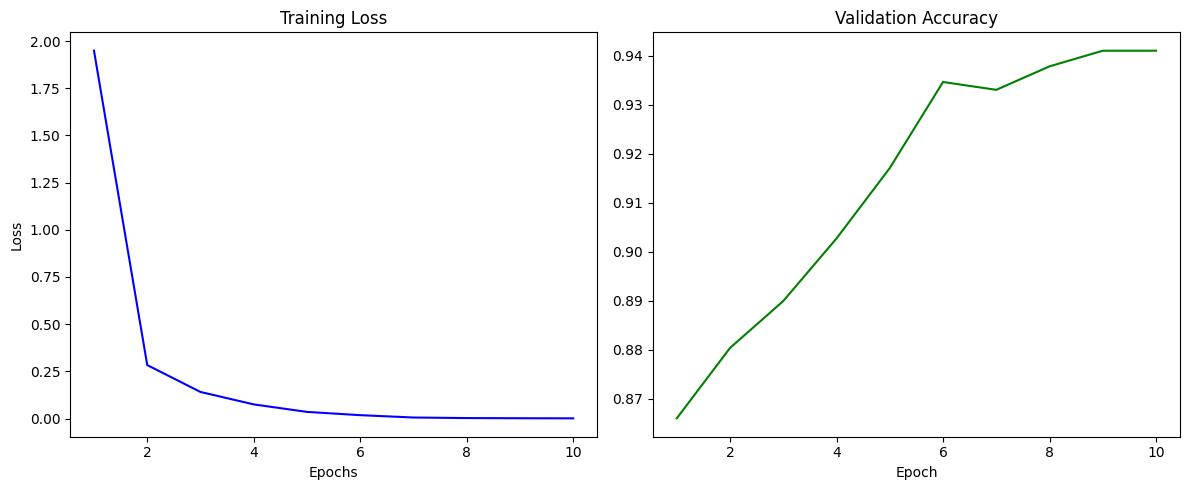

In [ ]:
import sys
import subprocess

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "matplotlib"])
    import matplotlib.pyplot as plt

if not history:
    raise ValueError("history is empty. Run the training cell first.")

epochs_x = [h.get("epoch", i + 1) for i, h in enumerate(history)]
train_loss = [h["train_loss"] for h in history]
val_acc = [h["val_acc"] for h in history]
val_err = [1.0 - a for a in val_acc]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs_x, train_loss, color="blue")
ax1.set_title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
# ax1.grid(True, alpha=0.3)
# ax1.legend()

ax2.set_title("Validation Accuracy")
ax2.plot(epochs_x, val_acc, color="green")
ax2.set_xlabel("Epoch")
# ax2.set_ylabel("Loss")
# ax2.grid(True, alpha=0.3)
# ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
best_model = AutoModelForImageClassification.from_pretrained(output_dir).to(device)
best_model.eval()
final_stats = evaluate(best_model, val_loader)
final_stats

{'val_loss': 0.2151776568895797, 'val_acc': 0.9537480063795853}

{'image': 'animals141\\dataset\\dataset\\puma-concolor\\puma-concolor_41_a9798a4a.jpg', 'true': 'puma-concolor', 'pred': 'puma-concolor', 'prob': 0.9997, 'correct': True}


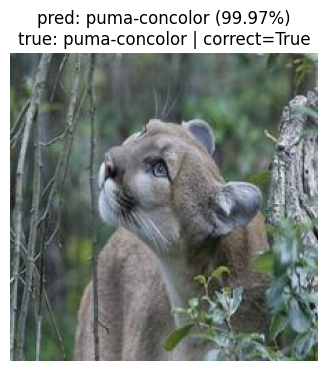

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

if len(val_idx) == 0:
    raise ValueError("val_idx is empty. Re-run the dataset split cell.")
rand_global_idx = random.choice(val_idx)
img_path, true_label = base_dataset.samples[rand_global_idx]
true_name = class_names[true_label]

img = Image.open(img_path).convert("RGB")

model_to_test = None
try:
    model_to_test = best_model
except NameError:
    model_to_test = AutoModelForImageClassification.from_pretrained(output_dir).to(device)

model_to_test.eval()
with torch.no_grad():
    inputs = processor(images=img, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)
    logits = model_to_test(pixel_values=pixel_values).logits
    probs = torch.softmax(logits, dim=-1)[0]
    pred_id = int(torch.argmax(probs).item())
    pred_name = class_names[pred_id]
    pred_prob = float(probs[pred_id].item())

is_correct = (pred_id == true_label)
print({
    "image": str(img_path),
    "true": true_name,
    "pred": pred_name,
    "prob": round(pred_prob, 4),
    "correct": is_correct,
})

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.title(f"pred: {pred_name} ({pred_prob:.2%})\ntrue: {true_name} | correct={is_correct}")
plt.show()

## Distill ViT → MobileNetV2 (CNN student)

In [ ]:
import copy
from torchvision import models

def build_mobilenetv2_student(num_classes: int, device: torch.device):
    student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    in_features = student.classifier[1].in_features
    student.classifier[1] = nn.Linear(in_features, num_classes)
    return student.to(device)

@torch.no_grad()
def evaluate_cnn(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    for images, labels in tqdm(data_loader, desc="eval(student)", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() * labels.size(0)
    acc = correct / max(1, total)
    avg_loss = total_loss / max(1, total)
    model.train()
    return {"val_loss": avg_loss, "val_acc": acc}

def distill_loss(student_logits, teacher_logits, labels, *, alpha=0.5, temperature=2.0):
    """alpha: weight on hard-label CE. (1-alpha): KD loss."""
    ce = F.cross_entropy(student_logits, labels)
    T = float(temperature)
    kd = F.kl_div(
        F.log_softmax(student_logits / T, dim=-1),
        F.softmax(teacher_logits / T, dim=-1),
        reduction="batchmean",
    ) * (T * T)
    return alpha * ce + (1.0 - alpha) * kd, {"ce": float(ce.item()), "kd": float(kd.item())}

def train_one_epoch_distill(student, teacher, data_loader, epoch, *, alpha=0.5, temperature=2.0, optimizer=None, scaler=None, use_amp=False, max_grad_norm=1.0):
    student.train()
    teacher.eval()
    running_loss = 0.0
    seen = 0
    pbar = tqdm(data_loader, desc=f"distill epoch {epoch}")
    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            teacher_logits = teacher(pixel_values=images).logits

        if use_amp:
            try:
                amp_ctx = torch.amp.autocast(device_type="cuda", enabled=True)
            except Exception:
                amp_ctx = torch.cuda.amp.autocast(enabled=True)
            with amp_ctx:
                student_logits = student(images)
                loss, parts = distill_loss(student_logits, teacher_logits, labels, alpha=alpha, temperature=temperature)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(student.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            student_logits = student(images)
            loss, parts = distill_loss(student_logits, teacher_logits, labels, alpha=alpha, temperature=temperature)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student.parameters(), max_grad_norm)
            optimizer.step()

        running_loss += loss.item() * labels.size(0)
        seen += labels.size(0)
        pbar.set_postfix(loss=running_loss / max(1, seen), ce=parts["ce"], kd=parts["kd"])

    return {"train_loss": running_loss / max(1, seen)}

In [ ]:
student_tmp = build_mobilenetv2_student(num_classes=num_classes, device=device)
images_tmp, labels_tmp = next(iter(train_loader))
with torch.no_grad():
    logits_tmp = student_tmp(images_tmp.to(device))
print("student logits shape:", tuple(logits_tmp.shape), "labels shape:", tuple(labels_tmp.shape))

NameError: name 'build_mobilenetv2_student' is not defined

In [ ]:
student_epochs = 50
student_lr = 3e-4
student_weight_decay = 1e-4
distill_alpha = 0.5
distill_temperature = 2.0

teacher = AutoModelForImageClassification.from_pretrained(output_dir).to(device)
teacher.eval()

student = build_mobilenetv2_student(num_classes=num_classes, device=device)

student_optimizer = torch.optim.AdamW(student.parameters(), lr=student_lr, weight_decay=student_weight_decay)
student_num_steps = student_epochs * len(train_loader)
student_warmup = int(0.05 * student_num_steps)
student_scheduler = get_linear_schedule_with_warmup(
    student_optimizer, num_warmup_steps=student_warmup, num_training_steps=student_num_steps
 )

student_use_amp = (device.type == "cuda")
try:
    student_scaler = torch.amp.GradScaler("cuda", enabled=student_use_amp)
except Exception:
    student_scaler = torch.cuda.amp.GradScaler(enabled=student_use_amp)
   
student_out_dir = Path("outputs/mobilenetv2-distilled")
student_out_dir.mkdir(parents=True, exist_ok=True)

best_student_acc = -1.0
student_history = []

for epoch in range(1, student_epochs + 1):
    stats_tr = train_one_epoch_distill(
        student, teacher, train_loader, epoch,
        alpha=distill_alpha, temperature=distill_temperature,
        optimizer=student_optimizer, scaler=student_scaler, use_amp=student_use_amp,
        max_grad_norm=max_grad_norm,
    )
    student_scheduler.step()

    stats_val = evaluate_cnn(student, val_loader)
    stats = {"epoch": epoch, **stats_tr, **stats_val}
    student_history.append(stats)
    print(stats)

    if stats_val["val_acc"] > best_student_acc:
        best_student_acc = stats_val["val_acc"]
        torch.save({
            "state_dict": student.state_dict(),
            "class_names": class_names,
            "model": "mobilenet_v2",
        }, student_out_dir / "best.pt")
        print(f"saved best student to {student_out_dir / 'best.pt'} (val_acc={best_student_acc:.4f})")

student_history

distill epoch 1: 100%|██████████| 176/176 [00:43<00:00,  4.08it/s, ce=5.17, kd=14.6, loss=9.68]


{'epoch': 1, 'train_loss': 9.67751874706962, 'val_loss': 5.155065919033458, 'val_acc': 0.003189792663476874}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.0032)


distill epoch 2: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s, ce=5.11, kd=14.3, loss=9.67]


{'epoch': 2, 'train_loss': 9.667580512436954, 'val_loss': 5.128500812932065, 'val_acc': 0.007974481658692184}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.0080)


distill epoch 3: 100%|██████████| 176/176 [00:43<00:00,  4.05it/s, ce=5.07, kd=14.2, loss=9.61]


{'epoch': 3, 'train_loss': 9.613357440991836, 'val_loss': 5.069005212525242, 'val_acc': 0.011164274322169059}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.0112)


distill epoch 4: 100%|██████████| 176/176 [00:43<00:00,  4.07it/s, ce=4.95, kd=14, loss=9.52]  


{'epoch': 4, 'train_loss': 9.521271879022772, 'val_loss': 4.987908270560573, 'val_acc': 0.017543859649122806}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.0175)


distill epoch 5: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s, ce=4.84, kd=13.9, loss=9.38]


{'epoch': 5, 'train_loss': 9.380129407752644, 'val_loss': 4.875413987435032, 'val_acc': 0.03349282296650718}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.0335)


distill epoch 6: 100%|██████████| 176/176 [00:42<00:00,  4.09it/s, ce=4.77, kd=13.8, loss=9.21]


{'epoch': 6, 'train_loss': 9.21022452549501, 'val_loss': 4.738833781064412, 'val_acc': 0.05422647527910686}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.0542)


distill epoch 7: 100%|██████████| 176/176 [00:43<00:00,  4.02it/s, ce=4.58, kd=12.8, loss=9]   


{'epoch': 7, 'train_loss': 9.003813526847146, 'val_loss': 4.563529230571059, 'val_acc': 0.10207336523125997}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.1021)


distill epoch 8: 100%|██████████| 176/176 [00:43<00:00,  4.06it/s, ce=4.29, kd=13.1, loss=8.77]


{'epoch': 8, 'train_loss': 8.766478300094604, 'val_loss': 4.377049737379692, 'val_acc': 0.16586921850079744}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.1659)


distill epoch 9: 100%|██████████| 176/176 [00:43<00:00,  4.03it/s, ce=4.15, kd=12.5, loss=8.47]


{'epoch': 9, 'train_loss': 8.465371110222556, 'val_loss': 4.147198987349369, 'val_acc': 0.22966507177033493}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.2297)


distill epoch 10: 100%|██████████| 176/176 [00:44<00:00,  3.94it/s, ce=3.71, kd=12.1, loss=8.14]


{'epoch': 10, 'train_loss': 8.136556218970906, 'val_loss': 3.9150505347305127, 'val_acc': 0.3014354066985646}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.3014)


distill epoch 11: 100%|██████████| 176/176 [00:44<00:00,  3.97it/s, ce=3.5, kd=11.6, loss=7.79] 


{'epoch': 11, 'train_loss': 7.786598541519859, 'val_loss': 3.6841633764750648, 'val_acc': 0.36044657097288674}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.3604)


distill epoch 12: 100%|██████████| 176/176 [00:44<00:00,  3.99it/s, ce=3.13, kd=11, loss=7.41]  


{'epoch': 12, 'train_loss': 7.410461187362671, 'val_loss': 3.4075396460209166, 'val_acc': 0.39553429027113235}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.3955)


distill epoch 13: 100%|██████████| 176/176 [00:44<00:00,  3.99it/s, ce=3.13, kd=10.7, loss=7.04]


{'epoch': 13, 'train_loss': 7.043470840562474, 'val_loss': 3.158403056660337, 'val_acc': 0.4481658692185008}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.4482)


distill epoch 14: 100%|██████████| 176/176 [00:43<00:00,  4.00it/s, ce=2.81, kd=10.5, loss=6.66]


{'epoch': 14, 'train_loss': 6.655822046778419, 'val_loss': 2.9158462166215813, 'val_acc': 0.48963317384370014}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.4896)


distill epoch 15: 100%|██████████| 176/176 [00:44<00:00,  3.95it/s, ce=2.58, kd=9.72, loss=6.27]


{'epoch': 15, 'train_loss': 6.274928859689019, 'val_loss': 2.6888560598546807, 'val_acc': 0.5167464114832536}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.5167)


distill epoch 16: 100%|██████████| 176/176 [00:44<00:00,  3.96it/s, ce=2.43, kd=9.11, loss=5.88]


{'epoch': 16, 'train_loss': 5.884280305017125, 'val_loss': 2.452583433528456, 'val_acc': 0.5486443381180224}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.5486)


distill epoch 17: 100%|██████████| 176/176 [00:43<00:00,  4.01it/s, ce=2.66, kd=9.46, loss=5.51]


{'epoch': 17, 'train_loss': 5.5058344304561615, 'val_loss': 2.2174990854004735, 'val_acc': 0.5709728867623605}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.5710)


distill epoch 18: 100%|██████████| 176/176 [00:44<00:00,  3.98it/s, ce=2.27, kd=8.38, loss=5.16]


{'epoch': 18, 'train_loss': 5.16060394319621, 'val_loss': 2.034571302374394, 'val_acc': 0.6028708133971292}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.6029)


distill epoch 19: 100%|██████████| 176/176 [00:43<00:00,  4.02it/s, ce=1.99, kd=7.76, loss=4.82]


{'epoch': 19, 'train_loss': 4.819698639891365, 'val_loss': 1.8669499843314503, 'val_acc': 0.6347687400318979}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.6348)


distill epoch 20: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s, ce=1.66, kd=7.31, loss=4.48]


{'epoch': 20, 'train_loss': 4.481183195655996, 'val_loss': 1.6973773524331515, 'val_acc': 0.6443381180223285}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.6443)


distill epoch 21: 100%|██████████| 176/176 [00:43<00:00,  4.06it/s, ce=1.5, kd=6.29, loss=4.15] 


{'epoch': 21, 'train_loss': 4.15052144093947, 'val_loss': 1.5540760559708688, 'val_acc': 0.6730462519936204}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.6730)


distill epoch 22: 100%|██████████| 176/176 [00:43<00:00,  4.08it/s, ce=1.38, kd=6.18, loss=3.84] 


{'epoch': 22, 'train_loss': 3.8443747244097968, 'val_loss': 1.422452799631268, 'val_acc': 0.6874003189792663}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.6874)


distill epoch 23: 100%|██████████| 176/176 [00:43<00:00,  4.05it/s, ce=0.987, kd=5.19, loss=3.56]


{'epoch': 23, 'train_loss': 3.560711206360297, 'val_loss': 1.284451855807023, 'val_acc': 0.7208931419457735}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.7209)


distill epoch 24: 100%|██████████| 176/176 [00:43<00:00,  4.05it/s, ce=1.14, kd=5.43, loss=3.27] 


{'epoch': 24, 'train_loss': 3.2669347389177843, 'val_loss': 1.1888658857801884, 'val_acc': 0.7240829346092504}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.7241)


distill epoch 25: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s, ce=1.39, kd=5.23, loss=3.01] 


{'epoch': 25, 'train_loss': 3.0090055018663406, 'val_loss': 1.071252060278751, 'val_acc': 0.7416267942583732}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.7416)


distill epoch 26: 100%|██████████| 176/176 [00:43<00:00,  4.03it/s, ce=0.894, kd=4.27, loss=2.77]


{'epoch': 26, 'train_loss': 2.7655688293955545, 'val_loss': 0.9792146127569998, 'val_acc': 0.7575757575757576}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.7576)


distill epoch 27: 100%|██████████| 176/176 [00:43<00:00,  4.04it/s, ce=0.689, kd=4.04, loss=2.52]


{'epoch': 27, 'train_loss': 2.5176278494975786, 'val_loss': 0.8894242253600125, 'val_acc': 0.7814992025518341}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.7815)


distill epoch 28: 100%|██████████| 176/176 [00:43<00:00,  4.06it/s, ce=0.523, kd=3.4, loss=2.29] 


{'epoch': 28, 'train_loss': 2.2873873128132387, 'val_loss': 0.8294361552173061, 'val_acc': 0.7910685805422647}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.7911)


distill epoch 29: 100%|██████████| 176/176 [00:43<00:00,  4.02it/s, ce=0.616, kd=3.54, loss=2.07]


{'epoch': 29, 'train_loss': 2.071359477259896, 'val_loss': 0.7595301330374759, 'val_acc': 0.8149920255183413}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8150)


distill epoch 30: 100%|██████████| 176/176 [00:42<00:00,  4.13it/s, ce=0.4, kd=2.77, loss=1.88]  


{'epoch': 30, 'train_loss': 1.878309633921493, 'val_loss': 0.7242023583614465, 'val_acc': 0.8165869218500797}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8166)


distill epoch 31: 100%|██████████| 176/176 [00:43<00:00,  4.08it/s, ce=0.567, kd=3.26, loss=1.71]


{'epoch': 31, 'train_loss': 1.7052248851819471, 'val_loss': 0.6550409313784452, 'val_acc': 0.8261562998405104}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8262)


distill epoch 32: 100%|██████████| 176/176 [00:43<00:00,  4.09it/s, ce=0.213, kd=1.96, loss=1.53]


{'epoch': 32, 'train_loss': 1.5326349525289102, 'val_loss': 0.6142140021354578, 'val_acc': 0.8325358851674641}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8325)


distill epoch 33: 100%|██████████| 176/176 [00:43<00:00,  4.09it/s, ce=0.174, kd=1.87, loss=1.38]


{'epoch': 33, 'train_loss': 1.3845787468281658, 'val_loss': 0.5897551873844397, 'val_acc': 0.84688995215311}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8469)


distill epoch 34: 100%|██████████| 176/176 [00:43<00:00,  4.08it/s, ce=0.247, kd=1.84, loss=1.25]


{'epoch': 34, 'train_loss': 1.2530501745641232, 'val_loss': 0.5541066295412359, 'val_acc': 0.84688995215311}


distill epoch 35: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s, ce=0.277, kd=2.17, loss=1.12] 


{'epoch': 35, 'train_loss': 1.121759005906907, 'val_loss': 0.5396317217908978, 'val_acc': 0.8564593301435407}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8565)


distill epoch 36: 100%|██████████| 176/176 [00:43<00:00,  4.09it/s, ce=0.216, kd=1.67, loss=1.01] 


{'epoch': 36, 'train_loss': 1.0146890326657079, 'val_loss': 0.5169796186010613, 'val_acc': 0.84688995215311}


distill epoch 37: 100%|██████████| 176/176 [00:43<00:00,  4.07it/s, ce=0.388, kd=2.36, loss=0.908] 


{'epoch': 37, 'train_loss': 0.9080890014090321, 'val_loss': 0.5011796787785191, 'val_acc': 0.861244019138756}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8612)


distill epoch 38: 100%|██████████| 176/176 [00:44<00:00,  4.00it/s, ce=0.154, kd=1.35, loss=0.817]  


{'epoch': 38, 'train_loss': 0.8166000978513197, 'val_loss': 0.48313091559843585, 'val_acc': 0.8676236044657097}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8676)


distill epoch 39: 100%|██████████| 176/176 [00:43<00:00,  4.08it/s, ce=0.0919, kd=0.968, loss=0.73] 


{'epoch': 39, 'train_loss': 0.7297970766032283, 'val_loss': 0.4769923125157516, 'val_acc': 0.8596491228070176}


distill epoch 40: 100%|██████████| 176/176 [00:42<00:00,  4.09it/s, ce=0.0398, kd=0.818, loss=0.658]


{'epoch': 40, 'train_loss': 0.6584834669801322, 'val_loss': 0.4696762925890264, 'val_acc': 0.8692185007974481}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8692)


distill epoch 41: 100%|██████████| 176/176 [00:43<00:00,  4.09it/s, ce=0.0438, kd=0.939, loss=0.599]


{'epoch': 41, 'train_loss': 0.5989577219906178, 'val_loss': 0.4430061759370746, 'val_acc': 0.8708133971291866}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8708)


distill epoch 42: 100%|██████████| 176/176 [00:43<00:00,  4.07it/s, ce=0.0244, kd=0.841, loss=0.544]


{'epoch': 42, 'train_loss': 0.5442599249495701, 'val_loss': 0.45498247209348175, 'val_acc': 0.8755980861244019}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8756)


distill epoch 43: 100%|██████████| 176/176 [00:43<00:00,  4.04it/s, ce=0.0694, kd=0.934, loss=0.498]


{'epoch': 43, 'train_loss': 0.49763877503573895, 'val_loss': 0.427728038750577, 'val_acc': 0.886762360446571}
saved best student to outputs\mobilenetv2-distilled\best.pt (val_acc=0.8868)


distill epoch 44: 100%|██████████| 176/176 [00:43<00:00,  4.04it/s, ce=0.0478, kd=0.878, loss=0.451] 


{'epoch': 44, 'train_loss': 0.4514629805291241, 'val_loss': 0.4381783713944601, 'val_acc': 0.8755980861244019}


distill epoch 45: 100%|██████████| 176/176 [00:43<00:00,  4.01it/s, ce=0.089, kd=0.92, loss=0.41]   


{'epoch': 45, 'train_loss': 0.4103923241861842, 'val_loss': 0.4406704391208752, 'val_acc': 0.8787878787878788}


distill epoch 46: 100%|██████████| 176/176 [00:43<00:00,  4.05it/s, ce=0.0581, kd=0.837, loss=0.373] 


{'epoch': 46, 'train_loss': 0.37290507927536964, 'val_loss': 0.4382158568221036, 'val_acc': 0.8787878787878788}


distill epoch 47: 100%|██████████| 176/176 [00:43<00:00,  4.01it/s, ce=0.00496, kd=0.459, loss=0.351]


{'epoch': 47, 'train_loss': 0.35088786550543527, 'val_loss': 0.42635548000700735, 'val_acc': 0.8835725677830941}


distill epoch 48: 100%|██████████| 176/176 [00:43<00:00,  4.05it/s, ce=0.0236, kd=0.526, loss=0.324] 


{'epoch': 48, 'train_loss': 0.3243767425248569, 'val_loss': 0.43581851418508866, 'val_acc': 0.8803827751196173}


distill epoch 49: 100%|██████████| 176/176 [00:43<00:00,  4.03it/s, ce=0.016, kd=0.529, loss=0.307]  


{'epoch': 49, 'train_loss': 0.30707412060688843, 'val_loss': 0.42376292407797855, 'val_acc': 0.886762360446571}


distill epoch 50: 100%|██████████| 176/176 [00:43<00:00,  4.05it/s, ce=0.017, kd=0.576, loss=0.289]  


{'epoch': 50, 'train_loss': 0.289169973439791, 'val_loss': 0.4264366437563676, 'val_acc': 0.886762360446571}


[{'epoch': 1,
  'train_loss': 9.67751874706962,
  'val_loss': 5.155065919033458,
  'val_acc': 0.003189792663476874},
 {'epoch': 2,
  'train_loss': 9.667580512436954,
  'val_loss': 5.128500812932065,
  'val_acc': 0.007974481658692184},
 {'epoch': 3,
  'train_loss': 9.613357440991836,
  'val_loss': 5.069005212525242,
  'val_acc': 0.011164274322169059},
 {'epoch': 4,
  'train_loss': 9.521271879022772,
  'val_loss': 4.987908270560573,
  'val_acc': 0.017543859649122806},
 {'epoch': 5,
  'train_loss': 9.380129407752644,
  'val_loss': 4.875413987435032,
  'val_acc': 0.03349282296650718},
 {'epoch': 6,
  'train_loss': 9.21022452549501,
  'val_loss': 4.738833781064412,
  'val_acc': 0.05422647527910686},
 {'epoch': 7,
  'train_loss': 9.003813526847146,
  'val_loss': 4.563529230571059,
  'val_acc': 0.10207336523125997},
 {'epoch': 8,
  'train_loss': 8.766478300094604,
  'val_loss': 4.377049737379692,
  'val_acc': 0.16586921850079744},
 {'epoch': 9,
  'train_loss': 8.465371110222556,
  'val_loss':

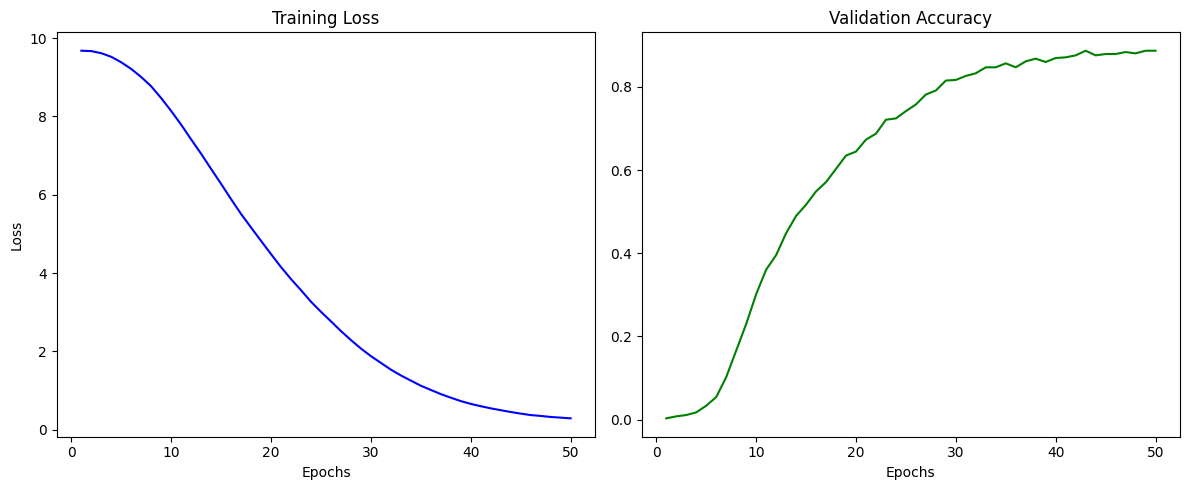

In [ ]:
import matplotlib.pyplot as plt

if not student_history:
    raise ValueError("student_history is empty. Run the distillation training cell first.")

sx = [h.get("epoch", i + 1) for i, h in enumerate(student_history)]
s_train_loss = [h["train_loss"] for h in student_history]
s_val_acc = [h["val_acc"] for h in student_history]
s_val_err = [1.0 - a for a in s_val_acc]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("Training Loss")
ax1.plot(sx, s_train_loss, color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.set_title("Validation Accuracy")
ax2.plot(sx, s_val_acc, color="green")
ax2.set_xlabel("Epochs")

plt.tight_layout()
plt.show()

In [ ]:
import json

ckpt_path = student_out_dir / "best.pt"
if not ckpt_path.exists():
    raise FileNotFoundError(f"Student checkpoint not found: {ckpt_path}. Run the distillation training cell first.")

ckpt = torch.load(ckpt_path, map_location=device)
student_best = build_mobilenetv2_student(num_classes=num_classes, device=device)
student_best.load_state_dict(ckpt["state_dict"], strict=True)

student_metrics = evaluate_cnn(student_best, val_loader)
print({"checkpoint": str(ckpt_path), **student_metrics})

state_dict_path = student_out_dir / "best_state_dict.pt"
torch.save(student_best.state_dict(), state_dict_path)

meta_path = student_out_dir / "best_meta.json"
meta = {
    "model": "mobilenet_v2",
    "num_classes": int(num_classes),
    "class_names": list(class_names),
    "val_metrics": {k: float(v) for k, v in student_metrics.items()},
}
meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

print("Saved:", state_dict_path)
print("Saved:", meta_path)

{'checkpoint': 'outputs\\mobilenetv2-distilled\\best.pt', 'val_loss': 0.427728038750577, 'val_acc': 0.886762360446571}
Saved: outputs\mobilenetv2-distilled\best_state_dict.pt
Saved: outputs\mobilenetv2-distilled\best_meta.json


## Train MobileNetV2 directly (baseline)
This trains a **MobileNetV2** classifier **from Animals141** (same `train_loader` / `val_loader`) using standard cross-entropy (no distillation).
It saves the best checkpoint to `outputs/mobilenetv2-direct/best.pt` and exports a plain `state_dict` + metadata JSON.

In [ ]:
from contextlib import nullcontext
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from tqdm.auto import tqdm

import json

def _get_amp_ctx(enabled: bool):
    if not enabled:
        return nullcontext()
    # torch>=2.0 preferred
    try:
        return torch.amp.autocast(device_type="cuda", enabled=True)
    except Exception:
        return torch.cuda.amp.autocast(enabled=True)

def train_one_epoch_cnn(
    model,
    data_loader,
    epoch: int,
    *,
    optimizer,
    scheduler=None,
    scaler=None,
    use_amp: bool = False,
    max_grad_norm: float = 1.0,
    desc: str = "train(baseline)",
):
    model.train()
    running_loss = 0.0
    seen = 0
    pbar = tqdm(data_loader, desc=f"{desc} epoch {epoch}")
    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with _get_amp_ctx(use_amp):
            logits = model(images)
            loss = F.cross_entropy(logits, labels)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * labels.size(0)
        seen += labels.size(0)
        pbar.set_postfix(loss=running_loss / max(1, seen))

    return {"train_loss": running_loss / max(1, seen)}

@torch.no_grad()
def evaluate_cnn_baseline(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    for images, labels in tqdm(data_loader, desc="eval(baseline)", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() * labels.size(0)
    acc = correct / max(1, total)
    avg_loss = total_loss / max(1, total)
    model.train()
    return {"val_loss": avg_loss, "val_acc": acc}

def build_mobilenetv2_classifier(num_classes: int, device: torch.device):
    m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    in_features = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_features, num_classes)
    return m.to(device)

In [ ]:
from transformers import get_linear_schedule_with_warmup

baseline_epochs = 30
baseline_lr = 3e-4
baseline_weight_decay = 1e-4

baseline_out_dir = Path("outputs/mobilenetv2-direct")
baseline_out_dir.mkdir(parents=True, exist_ok=True)

baseline_model = build_mobilenetv2_classifier(num_classes=num_classes, device=device)

baseline_optimizer = torch.optim.AdamW(
    baseline_model.parameters(), lr=baseline_lr, weight_decay=baseline_weight_decay
 )

baseline_steps = baseline_epochs * len(train_loader)
baseline_warmup = int(0.05 * baseline_steps)
baseline_scheduler = get_linear_schedule_with_warmup(
    baseline_optimizer, num_warmup_steps=baseline_warmup, num_training_steps=baseline_steps
 )

baseline_use_amp = (device.type == "cuda")
try:
    baseline_scaler = torch.amp.GradScaler("cuda", enabled=baseline_use_amp)
except Exception:
    baseline_scaler = torch.cuda.amp.GradScaler(enabled=baseline_use_amp)

baseline_history = []
best_baseline_acc = -1.0

for epoch in range(1, baseline_epochs + 1):
    train_stats = train_one_epoch_cnn(
        baseline_model,
        train_loader,
        epoch,
        optimizer=baseline_optimizer,
        scheduler=baseline_scheduler,
        scaler=baseline_scaler,
        use_amp=baseline_use_amp,
        max_grad_norm=1.0,
    )
    val_stats = evaluate_cnn_baseline(baseline_model, val_loader)
    row = {"epoch": epoch, **train_stats, **val_stats}
    baseline_history.append(row)
    print(row)

    if row["val_acc"] > best_baseline_acc:
        best_baseline_acc = row["val_acc"]
        torch.save(
            {
                "state_dict": baseline_model.state_dict(),
                "class_names": class_names,
                "model": "mobilenet_v2",
                "epoch": epoch,
                "val_acc": float(best_baseline_acc),
                "history": baseline_history,
            },
            baseline_out_dir / "best.pt",
        )
        print(f"saved best baseline to {baseline_out_dir / 'best.pt'} (val_acc={best_baseline_acc:.4f})")

baseline_history

In [ ]:
# Plot baseline (direct-training) metrics
import matplotlib.pyplot as plt

if not baseline_history:
    raise ValueError("baseline_history is empty. Run the baseline training cell first.")

bx = [h.get("epoch", i + 1) for i, h in enumerate(baseline_history)]
b_train_loss = [h["train_loss"] for h in baseline_history]
b_val_acc = [h["val_acc"] for h in baseline_history]
b_val_err = [1.0 - a for a in b_val_acc]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("Training Loss")
ax1.plot(bx, b_train_loss, color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.set_title("Validation Accuracy")
ax2.plot(bx, b_val_acc, color="green")
ax2.set_xlabel("Epochs")

plt.tight_layout()
plt.show()

In [ ]:
ckpt_path = baseline_out_dir / "best.pt"
if not ckpt_path.exists():
    raise FileNotFoundError(f"Baseline checkpoint not found: {ckpt_path}. Run the baseline training cell first.")

ckpt = torch.load(ckpt_path, map_location=device)
baseline_best = build_mobilenetv2_classifier(num_classes=num_classes, device=device)
baseline_best.load_state_dict(ckpt["state_dict"], strict=True)

baseline_metrics = evaluate_cnn_baseline(baseline_best, val_loader)
print({"checkpoint": str(ckpt_path), **baseline_metrics})

state_dict_path = baseline_out_dir / "best_state_dict.pt"
torch.save(baseline_best.state_dict(), state_dict_path)

meta_path = baseline_out_dir / "best_meta.json"
meta = {
    "model": "mobilenet_v2",
    "num_classes": int(num_classes),
    "class_names": list(class_names),
    "val_metrics": {k: float(v) for k, v in baseline_metrics.items()},
}
meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

print("Saved:", state_dict_path)
print("Saved:", meta_path)

# Comparisons
Evaluating best models and measuring accuracies and performance.

In [ ]:
from pathlib import Path
import torch

if "device" not in globals() or "num_classes" not in globals() or "val_loader" not in globals():
    raise RuntimeError("Expected device/num_classes/val_loader to be defined. Run the data setup cells first.")

if "build_mobilenetv2_classifier" not in globals():
    import torch.nn as nn
    from torchvision import models
    def build_mobilenetv2_classifier(num_classes: int, device: torch.device):
        m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        in_features = m.classifier[1].in_features
        m.classifier[1] = nn.Linear(in_features, num_classes)
        return m.to(device)

if "evaluate_cnn_baseline" not in globals():
    import torch.nn.functional as F
    from tqdm.auto import tqdm
    @torch.no_grad()
    def evaluate_cnn_baseline(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        total_loss = 0.0
        for images, labels in tqdm(data_loader, desc="eval", leave=False):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            logits = model(images)
            loss = F.cross_entropy(logits, labels)
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item() * labels.size(0)
        acc = correct / max(1, total)
        avg_loss = total_loss / max(1, total)
        model.train()
        return {"val_loss": avg_loss, "val_acc": acc}

distilled_dir = Path("outputs/mobilenetv2-distilled")
direct_dir = Path("outputs/mobilenetv2-direct")

distilled_ckpt_path = distilled_dir / "best.pt"
direct_ckpt_path = direct_dir / "best.pt"

missing = [p for p in [distilled_ckpt_path, direct_ckpt_path] if not p.exists()]
if missing:
    raise FileNotFoundError(
        "Missing checkpoints:\n" + "\n".join(str(p) for p in missing) +
        "\n\nTrain them first (distillation + baseline training cells)."
    )

distilled_ckpt = torch.load(distilled_ckpt_path, map_location=device)
direct_ckpt = torch.load(direct_ckpt_path, map_location=device)

distilled_model = build_mobilenetv2_classifier(num_classes=int(num_classes), device=device)
direct_model = build_mobilenetv2_classifier(num_classes=int(num_classes), device=device)

distilled_sd = distilled_ckpt.get("state_dict", distilled_ckpt)
direct_sd = direct_ckpt.get("state_dict", direct_ckpt)

distilled_model.load_state_dict(distilled_sd, strict=True)
direct_model.load_state_dict(direct_sd, strict=True)

print("Loaded:")
print(" - distilled:", distilled_ckpt_path)
print(" - direct:   ", direct_ckpt_path)

Loaded:
 - distilled: outputs\mobilenetv2-distilled\best.pt
 - direct:    outputs\mobilenetv2-direct\best.pt


In [ ]:
distilled_metrics = evaluate_cnn_baseline(distilled_model, val_loader)
direct_metrics = evaluate_cnn_baseline(direct_model, val_loader)

print("distilled:", distilled_metrics)
print("direct:   ", direct_metrics)

distilled: {'val_loss': 0.427728038750577, 'val_acc': 0.886762360446571}
direct:    {'val_loss': 0.02061336602164548, 'val_acc': 0.9952153110047847}


In [ ]:
from pathlib import Path
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from transformers import AutoModelForImageClassification

for name in ["device", "val_loader", "num_classes", "class_names"]:
    if name not in globals():
        raise RuntimeError(f"Expected `{name}` to be defined. Run the earlier setup cells first.")

vit_out_dir = Path("outputs/vit-animals")
if "output_dir" in globals():
    try:
        if Path(output_dir).exists():
            vit_out_dir = Path(output_dir)
    except Exception:
        pass

if not vit_out_dir.exists():
    raise FileNotFoundError(f"Fine-tuned ViT directory not found: {vit_out_dir}")

vit_tuned = AutoModelForImageClassification.from_pretrained(vit_out_dir).to(device)
vit_tuned.eval()

vit_base = AutoModelForImageClassification.from_pretrained(
    model_id,
    num_labels=int(num_classes),
    ignore_mismatched_sizes=True,
).to(device)
vit_base.eval()

print("Loaded ViT models:")
print(" - tuned:", vit_out_dir)
print(" - base:", model_id, "(fresh head)")

In [ ]:
@torch.no_grad()
def evaluate_vit(model, data_loader, *, desc="eval(vit)"):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    for pixel_values, labels in tqdm(data_loader, desc=desc, leave=False):
        pixel_values = pixel_values.to(device, non_blocking=True).contiguous()
        labels = labels.to(device, non_blocking=True)
        logits = model(pixel_values=pixel_values).logits
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() * labels.size(0)
    return {"val_loss": total_loss / max(1, total), "val_acc": correct / max(1, total)}

vit_tuned_metrics = evaluate_vit(vit_tuned, val_loader, desc="eval(vit_tuned)")
vit_base_metrics = evaluate_vit(vit_base, val_loader, desc="eval(vit_base_fresh_head)")

print("vit_tuned:", vit_tuned_metrics)
print("vit_base (fresh head):", vit_base_metrics)